Distribution of directed interaction weights inferred from Model RNN training:

In [1]:
import sys
import os
sys.path.append(os.path.abspath("C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code"))
import hdf5storage
import mat73
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math



import CURBD.curbd as curbd
import PyalData.pyaldata as pyaldata

In [2]:
data_dir_WTM350 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2" 
data_dir_WTM355 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyaldata2" 
data_dir_ASM351 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M351/AS-M351-pyaldata2" 
data_dir_ASM354 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/AS-M354/AS-M354-pyaldata2" 
data_dir_PSM365 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M365/PS-M365-pyaldata2" 
data_dir_PSM366 = "C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/PS-M366/PS-M366-pyaldata2" 

In [5]:
# consider all models, and no thalamus: 

weights_into_dcn = {'WT-M350':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}

for data_dir in [data_dir_WTM350, data_dir_WTM355, data_dir_ASM351, data_dir_ASM354, data_dir_PSM365, data_dir_PSM366]:
    animal_model = data_dir[-17:-10]
    files = os.listdir(data_dir)
    for file_name in files:
        fpath = os.path.join(data_dir, file_name)
        df = pyaldata.mat2dataframe(fpath, shift_idx_fields=True)
        df = pyaldata.select_trials(df, "success == 1")  # only consider successful trials
        df["trial_id"] = range(len(df))

        if len(df)>4:
            if df.m1_spikes[0].shape[1]>10 and df.dcn_spikes[0].shape[1]>10 and df.str_spikes[0].shape[1]>10:
                print(fpath)
                df = pyaldata.combine_time_bins(df, 5)
                spike_fields = ["m1_spikes","dcn_spikes","str_spikes"]

                for col in spike_fields:
                    df = pyaldata.remove_low_firing_neurons(df, col,  1)

                for col in spike_fields:
                    df = pyaldata.transform_signal(df, col,  'sqrt')

                df = pyaldata.merge_signals(df, spike_fields, "all_spikes")

                df = pyaldata.add_firing_rates(df, 'smooth')

                df = pyaldata.restrict_to_interval(df, "idx_mo", end_point_name=None, rel_start=-50, rel_end=100)  # consider half a second before and after movement onset

                # trial-average:
                avg_all_rates = df["all_rates"].mean()
                avg_m1_rates = df["m1_rates"].mean()
                avg_str_rates = df["str_rates"].mean()
                avg_dcn_rates = df["dcn_rates"].mean()

                # prepare inputs to the RNN training function
                activity = np.transpose(avg_all_rates)  # transpose to get NxT (neurons x timesteps); input to the RNN is an array NxT of smoothed firing rates

                Na = avg_m1_rates.shape[1]
                Nb = avg_dcn_rates.shape[1]
                Nc = avg_str_rates.shape[1]

                regions = []
                regions.append(['m1', np.arange(0, Na)])  # region m1 and the array containing indexes of m1 units in activity; order matters so that the indexes matches the order m1, str, dcn, thal in activity
                regions.append(['dcn', np.arange(Na, Na + Nb)])  # region str and the array containing indexes of str units in activity
                regions.append(['str', np.arange(Na + Nb, Na + Nb + Nc)])
                regions = np.array(regions, dtype=object)

                model = curbd.trainMultiRegionRNN(activity,
                                  dtData=df.bin_size[0],
                                  dtFactor=5,  # interpolation factor of RNN
                                  regions=regions,
                                  nRunTrain=100,
                                  verbose=False,
                                  plotStatus=False,
                                  nRunFree=1)
                
                print("Error for  "+file_name+": "+str(model['chi2s'][-1]))
                print("Explained variance for  "+file_name+": "+str(model['pVars'][-1]))

                weights_into_dcn[animal_model]['m1 to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][0][1]])
                weights_into_dcn[animal_model]['dcn to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][1][1]])
                weights_into_dcn[animal_model]['str to m1'].append(model["J"][model["regions"][0][1],:][:,model["regions"][2][1]])

                weights_into_dcn[animal_model]['m1 to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][0][1]])
                weights_into_dcn[animal_model]['dcn to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][1][1]])
                weights_into_dcn[animal_model]['str to dcn'].append(model["J"][model["regions"][1][1],:][:,model["regions"][2][1]])

                weights_into_dcn[animal_model]['m1 to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][0][1]])
                weights_into_dcn[animal_model]['dcn to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][1][1]])
                weights_into_dcn[animal_model]['str to str'].append(model["J"][model["regions"][2][1],:][:,model["regions"][2][1]])
                

                


C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350-pyaldata2\WT-M350_session1.mat
(63, 1)
(63, 1)
(63, 1)


C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
(63, 1)
Error for  WT-M350_session1.mat: 0.021198516263165393
Explained variance for  WT-M350_session1.mat: 0.9948497978266306
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M35

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M350_session2.mat: 0.010311363541774855
Explained variance for  WT-M350_session2.mat: 0.9964989847733432
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
(120, 1)
Error for  WT-M350_session3.mat: 0.0059702383532858035
Explained variance for  WT-M350_session3.mat:

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
(91, 1)
Error for  WT-M350_session4.mat: 0.014013566638151688
Explained variance for  WT-M350_session4.mat: 0.997283373592713
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M350/WT-M350

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
(84, 1)
Error for  WT-M350_session5.mat: 0.016935566041669046
Explained variance for  WT-M350_session5.mat: 0.9946953918426726
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
(105, 1)
Error for  WT-M350_session6.mat: 0.014807371950830739
Explained variance for  WT-M350_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
(437, 1)
Error for  WT-M355_session1.mat: 0.0016594918153770935
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
(118, 1)
Error for  WT-M355_session10.mat: 0.009657536962868826
Explained variance for  WT-M355_session10.mat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
(86, 1)
Error for  WT-M355_session11.mat: 0.014519432620462415
Explained variance for  WT-M355_session11.mat: 0.9908312093715039
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M355/WT-M355-pyal

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session12.mat: 0.0027064333081257145
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 

(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
(261, 1)
Error for  WT-M355_session13.mat: 0.0026642983256010178
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
(117, 1)
Error for  WT-M355_session14.mat: 0.007322859159288524
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [6

(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
(87, 1)
Error for  WT-M355_session15.mat: 0.014974169507223436
Explained variance for  WT-M355_session15.mat: 0.9921142561194154
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism d

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
(93, 1)
Error for  WT-M355_session17.mat: 0.017831267765635768
Explained variance for  WT-M355_session17.mat: 0.9847549768633574
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
(323, 1)
Error for  WT-M355_session18.mat: 0.0022622584440896913
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4

(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
(289, 1)
Error for  WT-M355_session19.mat: 0.002093662887044423
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
(463, 1)
Error for  WT-M355_session2.mat: 0.0014412613480022912
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
(82, 1)
Error for  WT-M355_session20.mat: 0.023686258262276227
Explained variance for  WT-M355_session20.mat: 0.9890162022032626
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism data/WT-M

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
(111, 1)
Error for  WT-M355_session21.mat: 0.012775770764466022
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
(225, 1)
Error for  WT-M355_session23.mat: 0.0032194367107866487
Explained variance for  WT-M355_ses

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
(434, 1)
Error for  WT-M355_session3.mat: 0.0017048729592922
Explained variance for  WT-M355_session

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
(471, 1)
Error for  WT-M355_session4.mat: 0.0014618749252153815
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [3

(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
(451, 1)
Error for  WT-M355_session5.mat: 0.0017044284449625696
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
(284, 1)
Error for  WT-M355_session6.mat: 0.0022569090215972887
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
(245, 1)
Error for  WT-M355_session7.mat: 0.0027020752094330876
Explained variance for  WT-M355_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
(95, 1)
Error for  WT-M355_session9.mat: 0.011944618944243611
Explained variance for  WT-M355_session9.mat: 0.9940019719002494
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/autism dat

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
(294, 1)
Error for  AS-M351_session1.mat: 0.002933085726901342
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
(304, 1)
Error for  AS-M351_session2.mat: 0.0024594883776436053
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
(235, 1)
Error for  AS-M351_session3.mat: 0.0031853896068110366
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
Error for  AS-M351_session4.mat: 0.003796268905195421
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
Error for  AS-M351_session7.mat: 0.0026385426496885423
Explained variance for  AS-M351_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1

(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
(254, 1)
Error for  AS-M351_session8.mat: 0.002807084736316924
Explained variance for  AS-M351_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
(195, 1)
Error for  AS-M354_session1.mat: 0.0035943393881726045
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
(165, 1)
Error for  AS-M354_session2.mat: 0.003855253777028522
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
(201, 1)
Error for  AS-M354_session4.mat: 0.0032689994276523028
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
(247, 1)
Error for  AS-M354_session5.mat: 0.0027731047888523964
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
(198, 1)
Error for  AS-M354_session6.mat: 0.003203670948622307
Explained variance for  AS-M354_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
(183, 1)
Error for  AS-M354_session7.mat: 0.0038370997261338293
Explained variance for  AS-M354_sess

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
(193, 1)
Error for  AS-M354_session8.mat: 0.004722563761575579
Explained variance for  AS-M354_session8.mat: 

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [2

(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
(271, 1)
Error for  PS-M365_session1.mat: 0.002604140299953456
Explained variance for  PS-M365_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
(189, 1)
Error for  PS-M365_session2.mat: 0.004772091828286898
Explained variance for  PS-M365_sessi

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
(83, 1)
Error for  PS-M365_session4.mat: 0.013702692825671322
Explained variance for  PS-M365_session4.mat: 0.9963428049483878
C:/Users/MARA/Desktop/IMPERIAL YEAR 4/Final year project/code/datasets/au

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\AppData\Local\Temp\ipykernel_25576\3680076814.py:35: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [4

(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
(176, 1)
Error for  PS-M366_session4.mat: 0.00395352561205796
Explained variance for  PS-M366_sessio

C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
C:\Users\MARA\Desktop\IMPERIAL YEAR 4\Final year project\code\PyalData\pyaldata\firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
(197, 1)
Error for  PS-M366_session5.mat: 0.0033456250169610624
Explained variance for  PS-M366_sess

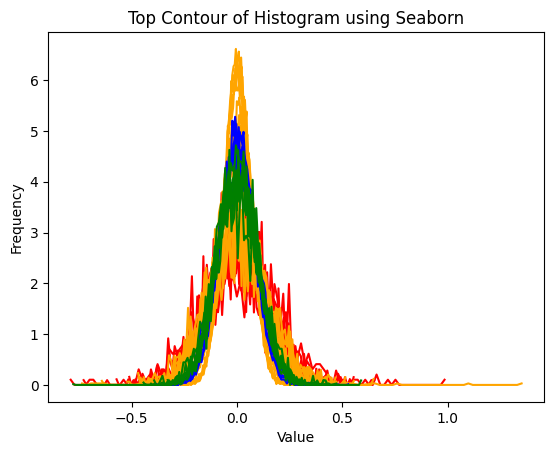

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


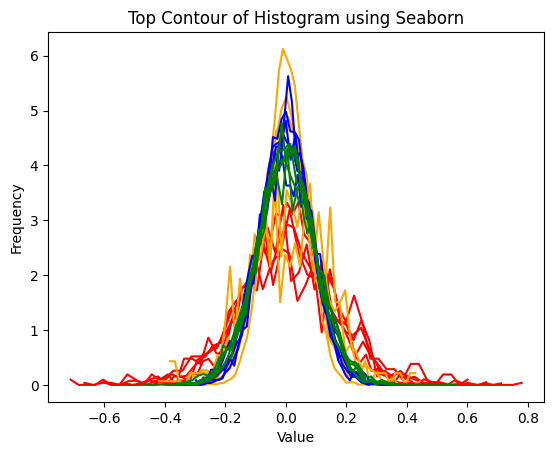

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["str to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=50, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


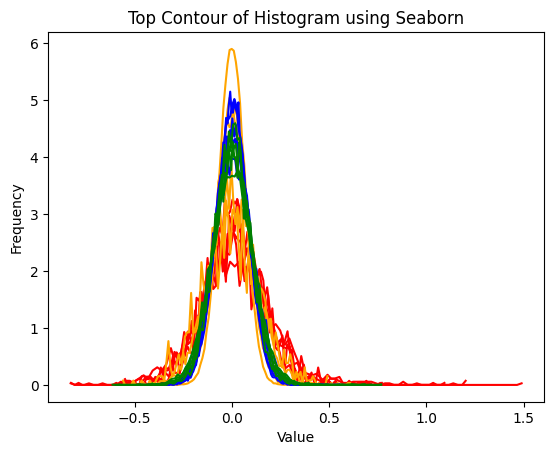

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for J in weights_into_dcn["WT-M350"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to dcn"][0:5]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Top Contour of Histogram using Seaborn')

# Show the plot
plt.show()


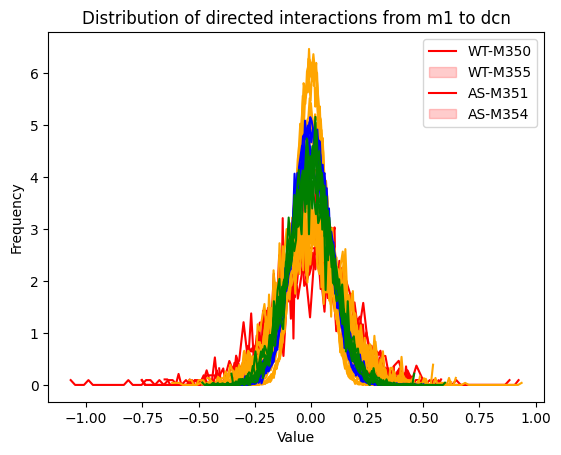

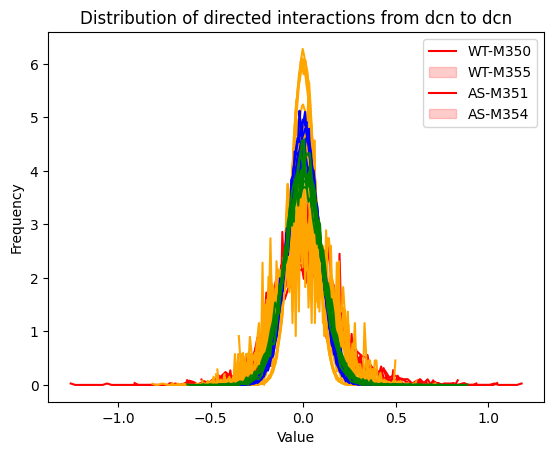

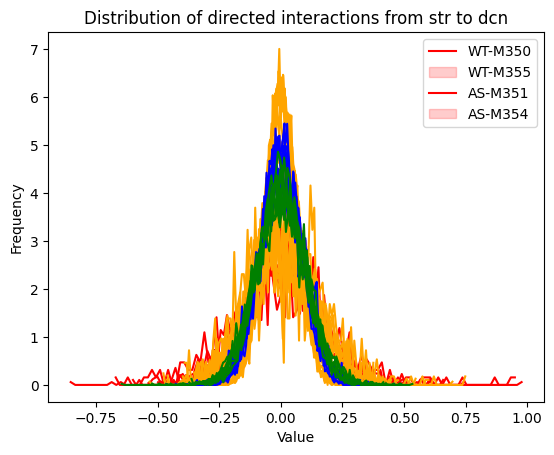

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Weights into dcn:

for J in weights_into_dcn["WT-M350"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red', label='WT-M350')

for J in weights_into_dcn["WT-M355"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange', label='WT-M355')

for J in weights_into_dcn["AS-M351"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue', label='AS-M351')

for J in weights_into_dcn["AS-M354"]["m1 to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green', label='AS-M354')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of directed interactions from m1 to dcn')
plt.legend(['WT-M350','WT-M355','AS-M351','AS-M354'])

# Show the plot
plt.show()





for J in weights_into_dcn["WT-M350"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of directed interactions from dcn to dcn')
plt.legend(['WT-M350','WT-M355','AS-M351','AS-M354'])

# Show the plot
plt.show()






for J in weights_into_dcn["WT-M350"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["str to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of directed interactions from str to dcn')
plt.legend(['WT-M350','WT-M355','AS-M351','AS-M354'])

# Show the plot
plt.show()


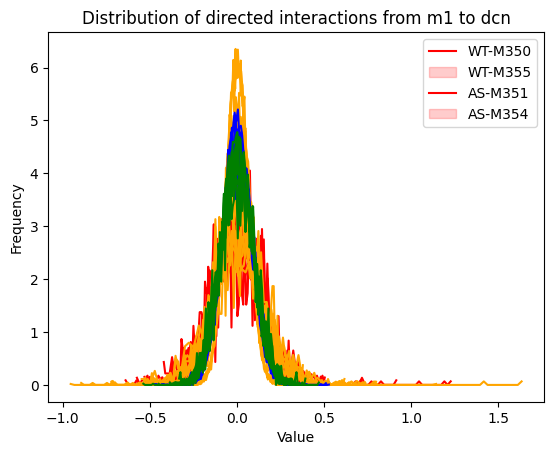

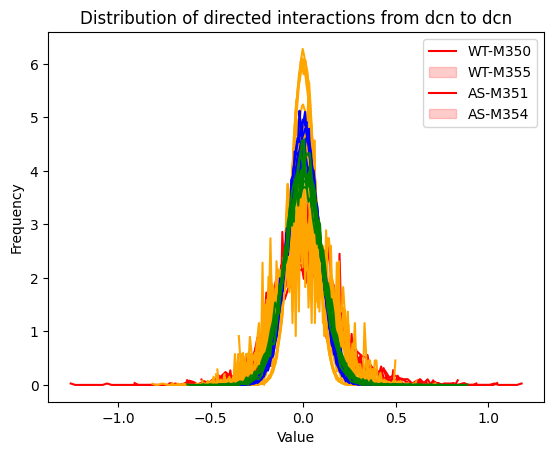

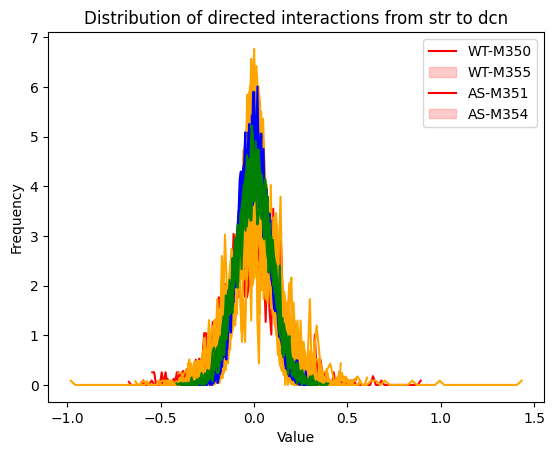

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Weights into dcn:

for J in weights_into_dcn["WT-M350"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red', label='WT-M350')

for J in weights_into_dcn["WT-M355"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange', label='WT-M355')

for J in weights_into_dcn["AS-M351"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue', label='AS-M351')

for J in weights_into_dcn["AS-M354"]["dcn to m1"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green', label='AS-M354')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of directed interactions from m1 to dcn')
plt.legend(['WT-M350','WT-M355','AS-M351','AS-M354'])

# Show the plot
plt.show()





for J in weights_into_dcn["WT-M350"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to dcn"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of directed interactions from dcn to dcn')
plt.legend(['WT-M350','WT-M355','AS-M351','AS-M354'])

# Show the plot
plt.show()






for J in weights_into_dcn["WT-M350"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='red')

for J in weights_into_dcn["WT-M355"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='orange')

for J in weights_into_dcn["AS-M351"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='blue')

for J in weights_into_dcn["AS-M354"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    sns.lineplot(x=bin_centers, y=counts, color='green')

# Set plot labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of directed interactions from str to dcn')
plt.legend(['WT-M350','WT-M355','AS-M351','AS-M354'])

# Show the plot
plt.show()


In [21]:
bins

array([-0.4182001 , -0.41049089, -0.40278167, -0.39507246, -0.38736325,
       -0.37965403, -0.37194482, -0.3642356 , -0.35652639, -0.34881718,
       -0.34110796, -0.33339875, -0.32568954, -0.31798032, -0.31027111,
       -0.30256189, -0.29485268, -0.28714347, -0.27943425, -0.27172504,
       -0.26401583, -0.25630661, -0.2485974 , -0.24088818, -0.23317897,
       -0.22546976, -0.21776054, -0.21005133, -0.20234212, -0.1946329 ,
       -0.18692369, -0.17921447, -0.17150526, -0.16379605, -0.15608683,
       -0.14837762, -0.14066841, -0.13295919, -0.12524998, -0.11754076,
       -0.10983155, -0.10212234, -0.09441312, -0.08670391, -0.0789947 ,
       -0.07128548, -0.06357627, -0.05586705, -0.04815784, -0.04044863,
       -0.03273941, -0.0250302 , -0.01732099, -0.00961177, -0.00190256,
        0.00580666,  0.01351587,  0.02122508,  0.0289343 ,  0.03664351,
        0.04435272,  0.05206194,  0.05977115,  0.06748037,  0.07518958,
        0.08289879,  0.09060801,  0.09831722,  0.10602643,  0.11

In [ ]:
# observed consistency between sessions of same mouse, plot mean and std of the distributions across all sessions for each mouse:



[-0.54391794 -0.53380175 -0.52368557 -0.51356939 -0.50345321 -0.49333702
 -0.48322084 -0.47310466 -0.46298848 -0.45287229 -0.44275611 -0.43263993
 -0.42252375 -0.41240756 -0.40229138 -0.3921752  -0.38205902 -0.37194283
 -0.36182665 -0.35171047 -0.34159429 -0.3314781  -0.32136192 -0.31124574
 -0.30112956 -0.29101338 -0.28089719 -0.27078101 -0.26066483 -0.25054865
 -0.24043246 -0.23031628 -0.2202001  -0.21008392 -0.19996773 -0.18985155
 -0.17973537 -0.16961919 -0.159503   -0.14938682 -0.13927064 -0.12915446
 -0.11903827 -0.10892209 -0.09880591 -0.08868973 -0.07857354 -0.06845736
 -0.05834118 -0.048225   -0.03810881 -0.02799263 -0.01787645 -0.00776027
  0.00235592  0.0124721   0.02258828  0.03270446  0.04282065  0.05293683
  0.06305301  0.07316919  0.08328538  0.09340156  0.10351774  0.11363392
  0.12375011  0.13386629  0.14398247  0.15409865  0.16421484  0.17433102
  0.1844472   0.19456338  0.20467957  0.21479575  0.22491193  0.23502811
  0.2451443   0.25526048  0.26537666  0.27549284  0

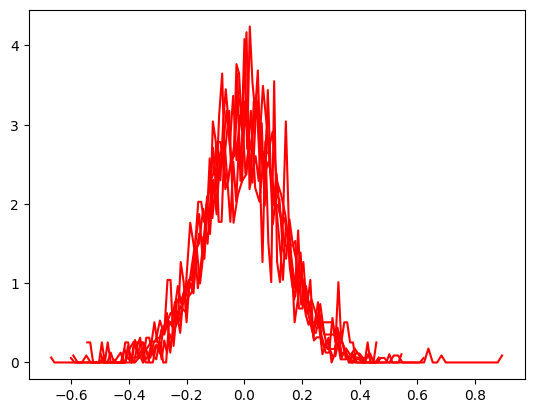

In [23]:
for J in weights_into_dcn["WT-M350"]["dcn to str"]:
    counts, bins = np.histogram(J, bins=100, density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    print(bin_centers)
    sns.lineplot(x=bin_centers, y=counts, color='red')

In [30]:
J_list = []

for J in weights_into_dcn["WT-M350"]["dcn to str"]:
    

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1847276134.py, line 4)

In [29]:
np.shape(J_list)

c:\Users\MARA\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(2,)

In [25]:
np.concatenate(weights_into_dcn["WT-M350"]["dcn to str"])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 39 and the array at index 1 has size 38

In [12]:
import json

# Convert the dictionary to a JSON-formatted string
json_string = json.dumps(weights_into_dcn, indent=4)

# Write the JSON string to a file
with open('distribution_of_weights_all.json', 'w') as json_file:
    json_file.write(json_string)

TypeError: Object of type ndarray is not JSON serializable

In [14]:
type(weights_into_dcn['WT-M355']['m1 to dcn'][0])

numpy.ndarray

In [15]:
np.shape(weights_into_dcn['WT-M355']['m1 to dcn'][0])

(364, 45)

In [18]:
np.shape(weights_into_dcn['WT-M355']['m1 to dcn'][0].tolist())

(364, 45)

In [19]:
# preprocess to be able to store in json file-- convert ndarray to list

weights_into_dcn_converted = {'WT-M350':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'WT-M355':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}, 
                'AS-M351':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'AS-M354':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M365':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]},
                'PS-M366':{'m1 to m1':[],'dcn to m1':[],'str to m1':[],'m1 to dcn':[],'dcn to dcn':[],'str to dcn':[],'m1 to str':[],'dcn to str':[],'str to str':[]}}


for animal_model in ['WT-M350','WT-M355','AS-M351','AS-M354','PS-M365','PS-M366']:
    for region_pair in ['m1 to m1','dcn to m1','str to m1','m1 to dcn','dcn to dcn','str to dcn','m1 to str','dcn to str','str to str']:
        for element in weights_into_dcn[animal_model][region_pair]:
            weights_into_dcn_converted[animal_model][region_pair].append(element.tolist())
            


In [20]:
import json

# Convert the dictionary to a JSON-formatted string
json_string = json.dumps(weights_into_dcn_converted, indent=4)

# Write the JSON string to a file
with open('distribution_of_weights_all.json', 'w') as json_file:
    json_file.write(json_string)